In [1]:
# Se importan las librerías necesarias
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import datetime
import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt

import os
os.environ['PROJ_LIB'] = '/opt/conda/pkgs/proj4-5.2.0-he1b5a44_1003/share/proj'
from mpl_toolkits.basemap import Basemap

In [2]:
# Se carga el fichero .json que contiene ubicaciones históricas previamente descargado desde Google
with open('Historial de ubicaciones.json', 'r') as fl:
    raw = json.loads(fl.read())
data = pd.DataFrame(raw['locations'])
del raw 

In [3]:
# Revisar la cantidad de datos que hay en el fichero
data.shape

(930545, 9)

In [4]:
# Conversión a las unidades habituales las coordenadas
data['latitudeE7'] = data['latitudeE7']/float(1e7) 
data['longitudeE7'] = data['longitudeE7']/float(1e7)
data['timestampMs'] = data['timestampMs'].map(lambda x: float(x)/1000) #to seconds
data['datetime'] = data.timestampMs.map(datetime.datetime.fromtimestamp)
# Renombrado de columnas
data.rename(columns={'latitudeE7':'latitude', 'longitudeE7':'longitude', 'timestampMs':'timestamp'}, inplace=True)
data.reset_index(drop=True, inplace=True)

In [5]:
# Se crean nuevas columnas con el año, mes, fecha y hora; por separado a partir de la información temporal original
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['date'] = data['datetime'].dt.date
data['hour'] = data['datetime'].dt.hour

In [6]:
# Se crea una nueva columna que indique si la precisión de la ubicación es mayor o menor de 5000 metros
data['value_accuracy'] = np.where(data['accuracy']>=5000, '1', '0')

In [7]:
# expantir todas las columnas que tengas listas de diccionarios 
#(GENERA UN NUEVO DATAFRAME DONDE "ACTIVITY" ESTÁ EXPANDIDA EN DISTINTAS ACTIVIDADES EL MISMO DÍA)
data_ex = data.apply(lambda x: x.explode()).reset_index(drop=True)

In [8]:
#crear una función para aplanar activity en varias columnas
#parte de la nueva columna activity expandida en data_ex

def flatten_json(nested_json, exclude=['']):
    """Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
            exclude: Keys to exclude from output.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name='', exclude=exclude):
        if type(x) is dict:
            for a in x:
                if a not in exclude: flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

In [9]:
#ejecutar función para aplanar activity y crear un nuevo dataframe
activity = pd.DataFrame([flatten_json(x) for x in data_ex['activity']])


In [10]:
#generar fecha de activity en dataframe "activity"
#primero se completan con 0 los null
activity['timestampMs'] = activity['timestampMs'].fillna(0)

#se transforma en datetime
activity['timestampMs'] = activity['timestampMs'].map(lambda x: float(x)/1000) #to seconds
activity['datetime_activity'] = activity.timestampMs.map(datetime.datetime.fromtimestamp)

#se completan con 0 los datetime que correspondan
activity.loc[activity['timestampMs'] == 0, 'datetime_activity'] = 0

In [11]:
#se crea un nuevo dataframe uniendo el de los datos originales con activity
data_new = pd.concat([data_ex, activity], axis=1)

#se elimina la columna "activity" original
data_new = data_new.drop(['activity'], axis=1)

#se ordena por "datetime" (esto es importante para luego estimar las distancias)
data_new_sort = data_new.sort_values(by='datetime')

In [12]:
#Se calcula la distancia en base a las latitudes y longitudes sobre el dataframe con activity expandido, 
#usando geopy (la distancia se calcula para cada intervalo de tiempo)
import geopy.distance

#se crean listas de lat y long
latitudes_list = data_new_sort['latitude'].to_list()
longitudes_list = data_new_sort['longitude'].to_list()

#cuenta de observaciones
cant = len(latitudes_list)

#lista vacía para almacenar distancias
distancias = []

#se hace un loop para todas las observaciones excepto una
for i in range (0,cant-1):
    coords_1 = (latitudes_list[i], longitudes_list[i])
    coords_2 = (latitudes_list[i+1], longitudes_list[i+1])
    
    distance = geopy.distance.geodesic(coords_1, coords_2).km
    
    distancias.append(distance)

#se agrega un dato con 0 al final para que la lista tenga el mismo largo que el dataframe
distancias.append(0)

#nueva columna en el dataframe
data_new_sort['dist'] = distancias

In [13]:
#sobre data original (sin activity) se calcula la distancia en base a las latitudes y longitudes, 
#usando geopy (la distancia se calcula para cada intervalo de tiempo)
#igual que antes...

import geopy.distance

latitudes_list = data['latitude'].to_list()
longitudes_list = data['longitude'].to_list()
cant = len(latitudes_list)
distancias = []

for i in range (0,cant-1):
    coords_1 = (latitudes_list[i], longitudes_list[i])
    coords_2 = (latitudes_list[i+1], longitudes_list[i+1])
    
    distance = geopy.distance.geodesic(coords_1, coords_2).km
    
    distancias.append(distance)
    
distancias.append(0)

data['dist'] = distancias

In [14]:
#se generan dataframes mensuales individuales por año (2020 en este caso) y se ponen en un diccionario, 
#eliminando los valores malos de precisión (más de 5000 metros)
#se genera una tabla de distancias recorridas por mes

data_new_sort_2020=data_new_sort[data_new_sort['year']==2020] 
data_new_sort_2020 = data_new_sort_2020[data_new_sort_2020['value_accuracy']=='0']

año_2020_dict ={}

for i in range (1,13):
    año_2020_dict[i] = data_new_sort_2020[data_new_sort_2020['month'] == i]


distancias_por_mes_2020 = pd.pivot_table(data_new_sort_2020, 
                                    values=['dist'],
                                    index=['month'], 
                                    #columns=['banco'],
                                    aggfunc='sum')

distancias_2020_list = distancias_por_mes_2020['dist'].to_list()
distancias_2020_list = [ '%.1f' % elem for elem in distancias_2020_list ]

print(distancias_por_mes_2020)
print ('total: ', distancias_por_mes_2020['dist'].sum())

              dist
month             
1      2994.788617
2      3370.448934
3      1090.550310
4       108.204370
5       277.049609
6       998.305021
7      1172.302010
8       750.175968
9       248.393505
10      987.742736
11     1264.611224
12     1776.747789
total:  15039.320095105046


In [15]:
#se generan dataframes mensuales individuales por año (2021 en este caso) y se ponen en un diccionario, 
#eliminando los valores malos de precisión (más de 5000 metros)
#se genera una tabla de distancias recorridas por mes

data_new_sort_2021=data_new_sort[data_new_sort['year']==2021] 
data_new_sort_2021 = data_new_sort_2021[data_new_sort_2021['value_accuracy']=='0']

año_2021_dict ={}

for i in range (1,13):
    año_2021_dict[i] = data_new_sort_2021[data_new_sort_2021['month'] == i]


distancias_por_mes_2021 = pd.pivot_table(data_new_sort_2021, 
                                    values=['dist'],
                                    index=['month'], 
                                    #columns=['banco'],
                                    aggfunc='sum')

distancias_2021_list = distancias_por_mes_2021['dist'].to_list()
distancias_2021_list = [ '%.1f' % elem for elem in distancias_2021_list ]

print(distancias_por_mes_2021)
print ('total: ', distancias_por_mes_2021['dist'].sum())

              dist
month             
1      2420.500364
2      1062.370563
3      6097.177006
total:  9580.047933040481


In [16]:
#información para crear mapas
# se extrae la información de interés, en este caso lats y longs del 2020, 
#creando una lista de lats y longs por mes a partir del diccionario de 2020

#diccionarios de variables de interés por mes
lats = {}
lons = {}
timestamp = {}
min_lats = []
min_lons = []
max_lats = []
max_lons = []

for i in range (1,13):
    lats[i] = año_2020_dict[i]['latitude'].values
    lons[i] = año_2020_dict[i]['longitude'].values
    timestamp[i] = año_2020_dict[i]['hour'].values
    
    #se establecen mínimos y máximos de lats y longs para cada mes a partir de los dicc de lats y lons
    min_lat = lats[i].min()
    min_lats.append(min_lat)
    
    min_lon = lons[i].min()
    min_lons.append(min_lon)
    
    max_lat = lats[i].max()
    max_lats.append(max_lat)
    
    max_lon = lons[i].max()
    max_lons.append(max_lon)

#Control
print (min_lats[1], min_lons[1], max_lats[1], max_lons[1])

-34.8835923 -64.2659424 -30.7014402 -58.3556225


In [17]:
#generar distancia máxima entre coordenadas de un mes puntual, podríamos necesitarlo para el mapa
coords_1_tamaño = (min_lats[1], min_lons[1])
coords_2_tamaño = (max_lats[1], max_lons[1])
    
distance_max = geopy.distance.geodesic(coords_1_tamaño, coords_2_tamaño).km

dist_metros = distance_max*1000

dist_metros

721964.498148936

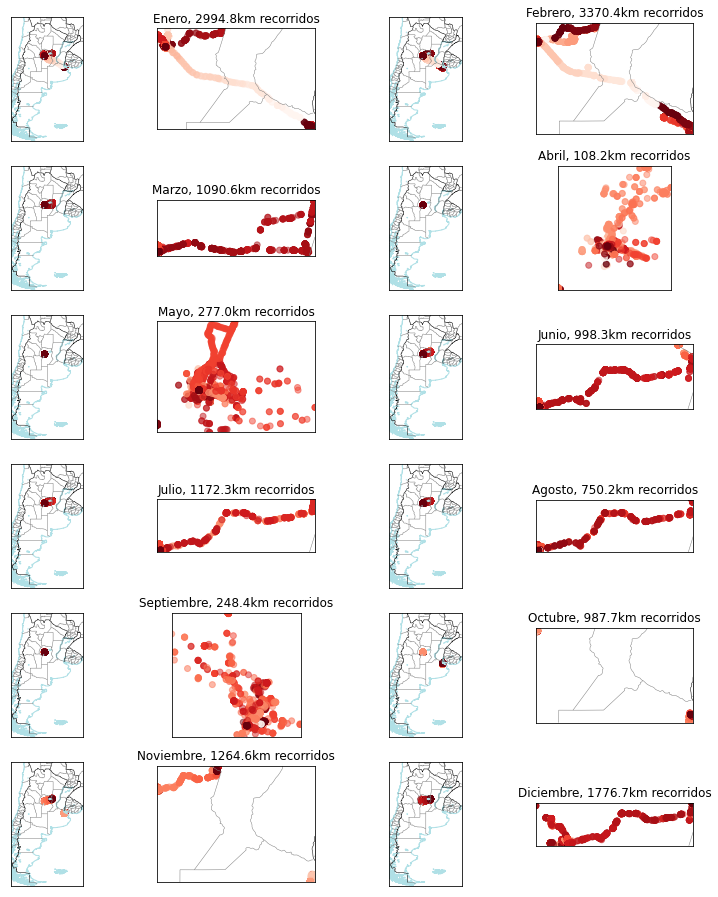

In [18]:
#se grafica individualmente cada mes en diferentes gráficos y a diferentes escalas
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']


fig = plt.figure(figsize=(13, 16))


for i in range (1, 13):
    if i < 2:
        j = i
    elif i < 3:
        j = i + 1
    elif i < 4:
        j = i + 2
    elif i < 5:
        j = i + 3
    elif i < 6:
        j = i + 4
    elif i < 7:
        j = i + 5
    elif i < 8:
        j = i + 6
    elif i < 9:
        j = i + 7
    elif i < 10:
        j = i + 8
    elif i < 11:
        j = i + 9
    elif i < 12:
        j = i + 10
    elif i < 13:
        j = i + 11
    
    ax = fig.add_subplot(6,4,j)
    #ax.set_title(f'{meses[i-1]}'+', '+f'{distancias_2020_list[i-1]}'+'km recorridos')
    map = Basemap(projection='cyl', resolution='h', 
                  llcrnrlon= -74, 
                  llcrnrlat = -56, 
                  urcrnrlon = -53, 
                  urcrnrlat=-20)
    
    #map.drawmapboundary(fill_color='aqua')
    #map.fillcontinents(color='coral',lake_color='aqua')
    map.drawcoastlines(color='powderblue')
    map.drawcountries(color='black')
    map.drawstates(color='grey')

    map.scatter(lons[i], lats[i], latlon=True,
                 c=timestamp[i], 
                 cmap='Reds', alpha=0.5)
    
    ax = fig.add_subplot(6,4,j+1)
    ax.set_title(f'{meses[i-1]}'+', '+f'{distancias_2020_list[i-1]}'+'km recorridos')
    map = Basemap(projection='cyl', resolution='h', 
                  llcrnrlon= min_lons[i-1], 
                  llcrnrlat = min_lats[i-1], 
                  urcrnrlon = max_lons[i-1], 
                  urcrnrlat=max_lats[i-1])
    
    #map.drawmapboundary(fill_color='aqua')
    #map.fillcontinents(color='coral',lake_color='aqua')
    #map.drawcoastlines(color='powderblue')
    map.drawcountries(color='black')
    map.drawstates(color='grey')

    map.scatter(lons[i], lats[i], latlon=True,
                 c=timestamp[i], 
                 cmap='Reds', alpha=0.5)
    


In [19]:
#Se estima una tabla de distancias por actividad realizada

distancias_por_actividad_2020 = pd.pivot_table(data_new_sort_2020, 
                                    values=['dist'],
                                    index=['activity_0_type', 
                                           'activity_1_type', 
                                           'activity_2_type', 
                                           'activity_3_type', 
                                           'activity_4_type', 
                                           'activity_5_type',
                                           'activity_6_type', 
                                           'activity_7_type', 
                                           'activity_8_type', 
                                           'activity_9_type', 
                                           'activity_10_type', 
                                           'activity_11_type'], 
                                    #columns=['month'],
                                    aggfunc='sum')

distancias_por_actividad_2020 = distancias_por_actividad_2020.reset_index()

In [20]:
pd.set_option('display.max_rows', None)
distancias_por_actividad_2020_ord = distancias_por_actividad_2020.sort_values(by='dist', ascending=False)
distancias_por_actividad_2020_ord

,activity_0_type,activity_1_type,activity_2_type,activity_3_type,activity_4_type,activity_5_type,activity_6_type,activity_7_type,activity_8_type,activity_9_type,activity_10_type,activity_11_type,dist
3,IN_VEHICLE,IN_ROAD_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,IN_BUS,IN_RAIL_VEHICLE,IN_TWO_WHEELER_VEHICLE,STILL,UNKNOWN,ON_BICYCLE,ON_FOOT,WALKING,2.794228
128,STILL,ON_FOOT,WALKING,IN_VEHICLE,IN_ROAD_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,IN_RAIL_VEHICLE,ON_BICYCLE,RUNNING,UNKNOWN,IN_TWO_WHEELER_VEHICLE,2.526601
21,IN_VEHICLE,IN_ROAD_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,IN_RAIL_VEHICLE,IN_TWO_WHEELER_VEHICLE,ON_BICYCLE,UNKNOWN,IN_BUS,ON_FOOT,WALKING,STILL,1.550715
33,IN_VEHICLE,IN_ROAD_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,IN_RAIL_VEHICLE,STILL,IN_TWO_WHEELER_VEHICLE,ON_FOOT,WALKING,UNKNOWN,IN_BUS,ON_BICYCLE,1.514085
13,IN_VEHICLE,IN_ROAD_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,IN_BUS,STILL,UNKNOWN,IN_TWO_WHEELER_VEHICLE,ON_BICYCLE,ON_FOOT,WALKING,IN_RAIL_VEHICLE,1.292358
28,IN_VEHICLE,IN_ROAD_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,IN_RAIL_VEHICLE,IN_TWO_WHEELER_VEHICLE,ON_FOOT,WALKING,UNKNOWN,ON_BICYCLE,STILL,IN_BUS,1.280152
35,IN_VEHICLE,IN_ROAD_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,IN_RAIL_VEHICLE,UNKNOWN,IN_TWO_WHEELER_VEHICLE,IN_BUS,ON_BICYCLE,ON_FOOT,WALKING,STILL,1.088894
47,IN_VEHICLE,IN_ROAD_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,IN_TWO_WHEELER_VEHICLE,IN_RAIL_VEHICLE,IN_BUS,ON_BICYCLE,ON_FOOT,WALKING,STILL,UNKNOWN,1.084404
51,IN_VEHICLE,IN_ROAD_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,IN_TWO_WHEELER_VEHICLE,IN_RAIL_VEHICLE,ON_BICYCLE,IN_BUS,UNKNOWN,ON_FOOT,WALKING,STILL,0.760326
62,IN_VEHICLE,IN_ROAD_VEHICLE,IN_FOUR_WHEELER_VEHICLE,IN_CAR,IN_TWO_WHEELER_VEHICLE,IN_RAIL_VEHICLE,STILL,ON_FOOT,WALKING,IN_BUS,ON_BICYCLE,UNKNOWN,0.669532


In [21]:
dict_act = {}
for i in range (0,11):
    list_act=distancias_por_actividad_2020_ord['activity_'+str(i)+'_type'].unique().tolist()
    dict_act[i]=list_act

list_all_act = dict_act[0]

for i in range (1, 11):
    list_all_act = list_all_act+dict_act[i]

In [22]:
list_all_act_uni= [] 
[list_all_act_uni.append(x) for x in list_all_act if x not in list_all_act_uni] 
list_all_act_uni

['IN_VEHICLE',
 'STILL',
 'ON_BICYCLE',
 'IN_ROAD_VEHICLE',
 'ON_FOOT',
 'IN_FOUR_WHEELER_VEHICLE',
 'WALKING',
 'IN_TWO_WHEELER_VEHICLE',
 'IN_CAR',
 'IN_RAIL_VEHICLE',
 'IN_BUS',
 'UNKNOWN',
 'RUNNING']

In [26]:
reemplazos_act = ['Car/Bus',
 'Still',
 'Bike',
 'Car/Bus',
 'On_Foot',
 'Car/Bus',
 'On_Foot',
 'Bike',
 'Car/Bus',
 'Car/Bus',
 'Car/Bus',
 '-',
 'On_Foot',]

act_reemp = pd.DataFrame(list(zip(list_all_act_uni, reemplazos_act)), columns =['viejo', 'nuevo']) 

In [27]:
distancias_por_actividad_2020_ord_2 = distancias_por_actividad_2020_ord.replace(list_all_act_uni, reemplazos_act)

In [28]:
distancias_por_actividad_2020_ord_2.head()

,activity_0_type,activity_1_type,activity_2_type,activity_3_type,activity_4_type,activity_5_type,activity_6_type,activity_7_type,activity_8_type,activity_9_type,activity_10_type,activity_11_type,dist
3,Car/Bus,Car/Bus,Car/Bus,Car/Bus,Car/Bus,Car/Bus,Bike,Still,-,Bike,On_Foot,On_Foot,2.794228
128,Still,On_Foot,On_Foot,Car/Bus,Car/Bus,Car/Bus,Car/Bus,Car/Bus,Bike,On_Foot,-,Bike,2.526601
21,Car/Bus,Car/Bus,Car/Bus,Car/Bus,Car/Bus,Bike,Bike,-,Car/Bus,On_Foot,On_Foot,Still,1.550715
33,Car/Bus,Car/Bus,Car/Bus,Car/Bus,Car/Bus,Still,Bike,On_Foot,On_Foot,-,Car/Bus,Bike,1.514085
13,Car/Bus,Car/Bus,Car/Bus,Car/Bus,Car/Bus,Still,-,Bike,Bike,On_Foot,On_Foot,Car/Bus,1.292358
